In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import njit, prange
import numba
import time
import gc

'import own functions'
from functions_2d import *



In [2]:

# Now evaluate n colonies, 

# L = 10
print('before, L=10, no. colonies:', 0.005*480*480)
print('ntr, L=10:', 3000*480*480, '\n')

# L = 20
print('after, L=20, no colonies:', 0.02*240*240)
print('ntr, L=20:', 12000*240*240, '\n')
# work work

before, L=10, no. colonies: 1152.0
ntr, L=10: 691200000 

after, L=20, no colonies: 1152.0
ntr, L=20: 691200000 



In [3]:
numba.__version__

'0.55.1'

In [4]:
'work!'

# What is the mean colony size, in concentric rings, if only the non-zero indexes are considered?

# (0) Lagre lmd infection() og lmd growth(), og se om de noensinne konvergerer mot 1, i simuleringen.
    # lmd infection() konvergerer definitivt mot en verdi >1.
        # for eta=16.0, ser vi at for dt=80, er sum_b=2800 for mye. Da krasjer koden. Det gir mening, for lmd inf().


'work!'

**Run simulation**

In [5]:
'run function'
# def run

# standard init. parameters
n = np.int32(550)        # (for now, n=400, as we need to speed up code); later n=500, for 1/4 plaque, as in 2016 paper we have 10 mm system?
m = np.int32(550)        

b0 = np.float32(0.33)      # density 1/300 micrometer**2, compared to 1/320 for 2016 paper
n0 = np.int32(3000)             # 30/micrometer**2, as in paper 2016
n_0 = n0
b1 = np.float32(1)              # det. solution
n1 = np.float32(3000)

p0 = np.int32(0)
i0 = np.int32(1)

# loc_i = np.array([n//2, m//2])  # (2, ), np.int32; 
loc_i = np.array([0, 0])  # (2, ), np.int32; drop I0 at upper left corner

L = np.float32(10)                 # 0.01 mm
Lz = np.float32(500)                # 0.5 mm
V_box = np.float32(L*L*Lz)        # 5000 micrometer**3
# ntr0 = np.int32(n0*V_box/(L*L*Lz))        # asd, delete later.


## initialize
B, ntr, P, I = init_2d(n, m, b0, n0, i0, loc_i)       # initialize system
# P += 1000
# B += 1000
B0 = np.copy(B)
ntr0 = np.copy(ntr)       
P0 = np.copy(P)
I0 = np.copy(I)


# parameters
dt = np.float32(60/3600)        # see how far you can increase dt, without running into issues for your stochastic events.
eta = np.float32(8*10**4)
D_p = np.float32(4*10**4)
D_n = np.float32(4*10**5)
tau = np.float32(42/60)

# for dt = 20 / 3600
# rad0p = 8           # prob. jump phg
# n0_circp = 8
# rad0n = 20          # prob. jump ntr
# n0_circn = 20

'use this, as dt=60 is our cap, for max. sum_b(i,j) = 52 000 ?'
# for dt = 60 / 3600
rad0p = 14           # prob. jump phg
n0_circp = 14
rad0n = 32          # prob. jump ntr
n0_circn = 32


p_circ_Dp = prob_jump(L, D_p, dt, rad_=rad0p, n=n0_circp)
p_circ_Dn = prob_jump(L, D_n, dt, rad_=rad0n, n=n0_circn)

# Simulation prm
't end:'
# t_end = np.float32(10)             # test that it runs..., 2016 paper, 10 hours
t_end = np.float32(dt*4)             # test that it runs..., 2016 paper, 10 hours
N = np.int32(t_end/dt)
time0 = np.float32(0)

'storing data'
i_skip = np.int32( 20 * dt/(60/3600))       # every 20th minutes (dt = 20h, then dt = 20h/60 = 20 min)


# lists, result                 asd, look at below, if it is actually correct
# list_b = [B]
list_sumb = [np.sum(B, axis=2)]
# list_b1 = [np.float32(1)]
list_ntr = [ntr]
list_time = [time0]
list_phg = [P]
# list_i = [I]
list_sumi = [np.sum(I, axis=2)]
list_time = [time0]
list_rhalf = [np.float32(0)]
list_lmd_max = [np.float32(0)]


# print stuff
print('t_end:', t_end)
print('N:', N)
print('dt:', dt*60, '[min]')
# print('i_skip:', i_skip/(60*60))
print('i_skip:', i_skip)
print('m, n:', m, n, '\n')

print('b0:', b0)
print('n0:', n0)
print('p0:', p0)
print('i0:', i0, '\n')
# print('sum B:', np.sum(B))
print('sum i0:', np.sum(I0))




t_end: 0.06666667
N: 4
dt: 1.0000000521540642 [min]
i_skip: 20
m, n: 550 550 

b0: 0.33
n0: 3000
p0: 0
i0: 1 

sum i0: 1


In [6]:
'Run Simulation'


'timer run'
start_time = time.process_time()        # start time

# for i in tqdm(range(N-1)):
for i in tqdm(range(2)):      # for debugging reinf()

    B, ntr, P, I, sum_b, lmd, _, _, _, _, _ = update(B, ntr, P, I, dt, V_box, eta, L, p_circ_Dp, p_circ_Dn, tau, n0_=n_0, shielding_=True, reinfection_=False, delta_r = 3)
    b1, n1, _ = growth_det(b1, n1, dt)
    time0 += dt
    
    'play around with gc.collect() below.'
    if i%25 == 0:                 # with gc.collect()
        gc.collect()                         # %25 works better than say %40

'end timer'
end_time = time.process_time() # Record the end time
elapsed_time = end_time - start_time # Calculate the elapsed time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Time taken to run the function: {minutes:.0f} minutes and {seconds:.1f} seconds", '\n')


print('b0:', b0)
# print('shape list_sumb:', np.shape(list_sumb))

'for t_end=8h, gc.collect() %25, it takes ~102 min to run, in machine time (145 min on my latop).'


print('lmd, update():', lmd)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:26<00:00, 43.17s/it]

Time taken to run the function: 1 minutes and 24.8 seconds 

b0: 0.33
lmd, update(): 0.03359789773821831


In [7]:
# asd asd

In [8]:
# Print relevant shapes, then rearrange

print('n:', n)
print('m:', m, '\n')

print('shape list_sumb:', np.shape(list_sumb))
# print('shape list_meanb:', np.shape(list_meanb), '\n')

print('shape list ntr:', np.shape(list_ntr))
print('shape list_phg:', np.shape(list_phg))
print('shape list sum i:', np.shape(list_sumi), '\n')

print('shape list time:', np.shape(list_time))
print('shape list r_half:', np.shape(list_rhalf))

n: 550
m: 550 

shape list_sumb: (1, 550, 550)
shape list ntr: (1, 550, 550)
shape list_phg: (1, 550, 550)
shape list sum i: (1, 550, 550) 

shape list time: (1,)
shape list r_half: (1,)


**Plaque: Set prm=b0, Dp, etc.**

In [ ]:
'Prm plaque1 - b0'

# list_b0 = np.array([0.05, 0.1, 0.333, 0.5, 0.75, 1], dtype=np.float32)                     # actual simulation variables

list_b0 = np.array([0.33333], dtype=np.float32)                           # very quick simulation
# list_b0 = np.array([1.0], dtype=np.float32)                           # very quick simulation

list_density = list_b0/L**2


print('list_b0:', list_b0)
print('list_density:', list_density, '[1/micrometer**2]', '\n')

list_b0: [1.]
list_density: [0.01] [1/micrometer**2] 



In [10]:
'Prm plaque2 - Dp'

# list_Dp = np.array(np.array([0.2, 0.5, 1.0, 2.0, 4.0, 8.0])*10**4, dtype=np.float32)      # all values

list_Dp = np.array(np.array([8.0])*10**4, dtype = np.float32)     

print('list_Dp:', list_Dp, '\n')


list_Dp: [80000.] 



In [11]:
'Prm plaque3 - eta'
# list_eta = np.array(np.array([0.5, 1.0, 2.0, 4.0, 8.0, 16.0])*10**4, dtype = np.float32)      # all values
# list_eta = np.array(np.array([2.0, 4.0])*10**4, dtype = np.float32)        # save results 
# list_eta = np.array(np.array([8.0])*10**4, dtype = np.float32)        # save results 
list_eta = np.array(np.array([16.0])*10**4, dtype = np.float32)        # save results 

print('list_eta:', list_eta, '\n')

list_eta: [160000.] 



In [12]:
'Prm plaque4 - tau'
# list_tau = np.array(np.array([0.50, 0.75, 1.0, 2.0, 3.0, 4.0])*42/60, dtype = np.float32)        # all valuse, new
# list_tau = np.array(np.array([0.25, 0.50, 1.0, 2.0, 3.0, 4.0])*42/60, dtype = np.float32)        # all values, old

list_tau = np.array(np.array([0.75])*42/60, dtype = np.float32)        # quick simulation

print('list_tau:', list_tau, '\n')


list_tau: [0.525] 



In [13]:

60*50/3600

0.8333333333333334

**set parameters**

In [ ]:

'run function'
# def run

# standard init. parameters
m = np.int32(400)           # b0 = 0.05, mn = 420
n = np.int32(400)        
# m = np.int32(260)           # b0 = 0.33, mn = 420, well-mixed
# n = np.int32(260)        

b0 = np.float32(0.3333333)      # density 1/300 micrometer**2, compared to 1/320 for 2016 paper
n0 = np.int32(3000)             # 30/micrometer**2, as in paper 2016
n_0 = n0
p0 = np.int32(0)
i0 = np.int32(1)

# loc_i = np.array([n//2, m//2])  # (2, ), np.int32; 
loc_i = np.array([0, 0])  # (2, ), np.int32; drop I0 at upper left corner


L = np.float32(10)                 # 0.01 mm
Lz = np.float32(500)                # 0.5 mm
V_box = np.float32(L*L*Lz)        # 5000 micrometer**3
# ntr0 = np.int32(n0*V_box/(L*L*Lz))        # asd, correct later.


## initialize                                           
B, ntr, P, I = init_2d(n, m, b0, n0, i0, loc_i)       # initialize system
B0 = np.copy(B)
Ntr0 = np.copy(B)       # change name?
P0 = np.copy(P)
I0 = np.copy(I)

# -----------------------------------------------------------------------------

# run parameters
dt = np.float32(50/3600)        # see how far you can increase dt, without running into issues for your stochastic events.
# dt = np.float32(50/3600)        # for b0=0.05, set dt=30
eta = np.float32(8*10**4)
D_p = np.float32(4*10**4)
D_n = np.float32(4*10**5)
# D_n = np.float32(3*10**6)

tau = np.float32(42/60)
time0 = np.float32(0)

'given dt, evaluate size of p_circ, gauss diffusion'
rad0p, n0_circp, rad0n, n0_circn = eval_p_circ(dt)
    # for realistic Dn = 3*10**6 ? Or maybe not, nutrient numbers < 3000.

'for D_n = 3*10**6, dt=50/3600'
# rad0n = 40          # prob. jump ntr
# n0_circn = 40

print('dt [s]:', dt*3600)
print('rad0p:', rad0p)
print('rad0n:', rad0n, '\n')


p_circ_Dp = prob_jump(L, D_p, dt, rad_=rad0p, n=n0_circp)
p_circ_Dn = prob_jump(L, D_n, dt, rad_=rad0n, n=n0_circn)

't end'
t_end = 10                    
# t_end = 5.2                  
trials = 1                     
N = np.int32(t_end/dt)


'storing data, sumb, phg, etc.'
i_skip = np.int32( 10 * dt/(60/3600))       # dt * 20/60, gives very 20th minute, when dt is in [h]
i_skip_rhalf = np.int32( 60 * dt/(1/60))      # save r_half every 10th minute

# -----------------------------------------------------------------------------

'lists, result'                         # asd, look at below, if it is actually correct
# list_b = [B]
list_sumb = [np.sum(B, axis=2)]
list_phg = [P]
list_i = [I]
list_ntr = [ntr]
list_sumi = [np.sum(I, axis=2)]
list_time = [time0]
list_rhalf_all = []
# list_lmd_max = [np.float32(0)]
list_lmd_max = []   # consider appending a value, to end of list_lmd_max, after simulation.
list_inf_moi = [np.zeros_like(P)]
list_healthy_surf = [np.zeros_like(P)]
list_ratio = [np.zeros_like(P)]
list_inf_healthy = [np.zeros_like(P)]


'store results'
list_all_trials = []
list_plq_size = []

# -----------------------------------------------------------------------------

# Print stuff
print('Simulation Settings:')
print('trials:', trials)
print('t_end:', t_end)
print('dt:', dt*60, '[min]', '\n')

print('N:', N)
print('m, n:', m, n, '\n')
print('i_skip:', i_skip, '\n')

print('b0:', b0)
print('n0:', n0)
print('p0:', p0)
print('i0:', i0, '\n')
# print('sum B:', np.sum(B))
print('loc_i:', loc_i)
print('sum i0:', np.sum(I0))


dt [s]: 60.00000312924385
rad0p: 14
rad0n: 34 

Simulation Settings:
trials: 1
t_end: 10
dt: 1.0000000521540642 [min] 

N: 599
m, n: 320 320 

i_skip: 10 

b0: 0.3333333
n0: 3000
p0: 0
i0: 1 

loc_i: [0 0]
sum i0: 1


**simulate**

In [15]:
print('bo:', b0)
print('D_p:', D_p)
print('eta:', eta)
print('tau:', tau, '\n')

bo: 0.3333333
D_p: 40000.0
eta: 80000.0
tau: 0.7 



In [ ]:
'Run Plaque0 - arbitrary prm'

print('loc_i:', loc_i)
print('trials:', trials, '\n')

# maybe change to 2D array at some point.
list_sumb_end = []
list_phg_end = []
list_sumi_end = []
list_ntr_end = []
save_lmd = 0        # delete later, asd.

'timer run'
start_time = time.process_time()        # start time

'work: include index here, to switch between parameters.'
# loop over list_prm(i)
for b0 in list_b0:
# for D_p in list_Dp:           # remember p_circ_Dp, below.
# for eta in list_eta:
# for tau in list_tau:        # change x3

    list_prm_ = list_b0       # for saving later
    # list_prm_ = list_Dp
    # list_prm_ = list_eta        
    # list_prm_ = list_tau

    # reevaluate, if Dp should vary
    p_circ_Dp = prob_jump(L, D_p, dt, rad_=rad0p, n=n0_circp)                           # just always update, for Dp

    print('b0:', b0)            # print current parameter value
    # print('Dp:', D_p)
    # print('eta:', eta, '\n')
    # print('tau:', tau)

    trials_prm = []                          # storing plaque sizes for each trial
    list_rhalf_trial = []                    # storing r_half for all trials, given a prm. value
    store_sumb = []
    store_phg = []
    store_sumi = []
    store_ntr = []

    'loop over trials'
    for j in range(trials):
        print('trial j:', j, '\n')

        list_rhalf = [np.float32(0)]
        time0 = np.float32(0)                    # reset time

        # initialize        
        B, ntr, P, I = init_2d(n, m, b0, n0, i0, loc_i)       # initialize system

        # lists, result                 asd, look at below, if it is actually correct
        list_sumb = [np.sum(B, axis=2)]
        list_phg = [P]
        list_sumi = [np.sum(I, axis=2)]
        list_ntr = [ntr]
        list_time = [time0]
        list_inf_moi = [np.zeros_like(P)]
        list_healthy_surf = [np.zeros_like(P)]
        list_ratio = [np.zeros_like(P)]
        list_lysis = [np.zeros_like(P)]
        list_inf_healthy = [np.zeros_like(P)]


        'run simulation'
        for i in tqdm(range(N-1)):          # asd asd, consider removing lambda below. delete.         
            B, ntr, P, I, sum_b, lmd, _, _, _, _, _ = update(B, ntr, P, I, dt, V_box, eta, L, p_circ_Dp, p_circ_Dn, tau, n0_=n_0, shielding_=False, reinfection_=False, delta_r=1)

            list_lmd_max.append(lmd)        # np.float32, (N-1); track lmd infections(), look for error.
            if lmd > 0.98 and save_lmd < 1:     # maybe delete later
                np.save('list_lmd_max_error.npy', np.array(list_lmd_max))
                np.save('sum_b_error.npy', np.array(sum_b))
                save_lmd += 1

            time0 += dt     # asd, where is time reset above?
            
            # Save profile, sumb, phg, etc.
            if i% i_skip == 0:                  # now saves every 10th minute
                list_sumb.append(sum_b)
                list_phg.append(P)
                list_sumi.append(np.sum(I, axis=2))
                list_ntr.append(ntr)
                list_time.append(time0)
                # list_inf_moi.append(inf_moi)        # (n, m), np.float32; store inf. moi. for each time step 
                # list_healthy_surf.append(n_healthy)  # (n, m), np.float32; store healthy inf. for each time step
                # list_ratio.append(ratio)            # (n, m), np.float32; store ratio for each time step
                # list_lysis.append(lysis)            # (n, m), np.float32; store lysis for each time step
                # list_inf_healthy.append(inf_healthy)        # (n, m), np.float32; store inf. healthy for each time step

            # save r_half
            if i% i_skip_rhalf == 0:                                        # save every 10th minute, at the moment
                r_half0 = calc_r_half_corner(sum_b, P, np.sum(I, axis=2), L)
                list_rhalf.append(r_half0)              # (x, ) store r_half

            'play around with gc.collect() below.'
            if i%25 == 0:                 # with gc.collect()           %25 seems good.
                gc.collect()

        # evaluate plaque size
        plaque = calc_r_half_corner(sum_b, P, np.sum(I, axis=2), L)        # plaque size, in micrometer
        if plaque==0:
            print('error: plq = 0 micrometer')
            print('r_half:', plaque)
        
        trials_prm.append(plaque)        # store plaque size for each trial
        list_rhalf_trial.append(np.array(list_rhalf))   # (x , x') store r_half for all trials - 2D list
        
        # list sumb (N /i_skip, n, m)
        store_sumb.append(np.array(list_sumb))      # save all profiles, for each trial: sum_b, phg, etc.
        store_phg.append(np.array(list_phg))        # (all trials,  N/i_skip,  n, m)
        store_sumi.append(np.array(list_sumi))
        store_ntr.append(np.array(list_ntr))

        # save end results
        list_sumb_end.append(sum_b)
        list_phg_end.append(P)
        list_sumi_end.append(np.sum(I, axis=2))
        list_ntr_end.append(ntr)      
    
    trials_prm = np.array(trials_prm)
    list_all_trials.append(trials_prm)               # store plaque sizes for each value of b0
    list_plq_size.append(np.mean(trials_prm))        # store mean plaque size for each b0
    list_rhalf_all.append(np.array(list_rhalf_trial))  # (x, x', x''), 3D list: store r_half (x, ), for each trial (x, x'), for each prm (x, x', x'')

    # for saving results
    save_list_prm = np.array(list_prm_)
    save_all_trials = np.array(list_all_trials)
    save_plq_size = np.array(list_plq_size)
    save_rhalf_all = np.array(list_rhalf_all)   # 
    save_sumb = np.array(store_sumb)            # 4D, potentially. huh.
    save_phg = np.array(store_phg)
    save_sumi = np.array(store_sumi)
    save_ntr = np.array(store_ntr)


'end timer'
end_time = time.process_time() # Record the end time
elapsed_time = end_time - start_time # Calculate the elapsed time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Time taken to run the function: {minutes:.0f} minutes and {seconds:.1f} seconds", '\n')


' 2 h to run, shielding, b0=0.33, dt=30 though.'

loc_i: [0 0]
trials: 1 

b0: 1.0
trial j: 0 



  2%|▏         | 13/598 [01:24<1:04:25,  6.61s/it]

In [ ]:
# # for saving results
save_list_prm = np.array(list_prm_)
save_all_trials = np.array(list_all_trials)
save_plq_size = np.array(list_plq_size)
save_rhalf_all = np.array(list_rhalf_all)   # 
save_sumb = np.array(store_sumb)            # 4D, potentially. huh.
save_phg = np.array(store_phg)
save_sumi = np.array(store_sumi)
save_ntr = np.array(store_ntr)
print('sape store_phg:', np.shape(store_phg))

sape store_phg: (1, 61, 360, 360)


In [ ]:
# Print shapes
print('shape save_sumb:', np.shape(sum_b))
print('shape save_phg:', np.shape(P))
print('shape save_sumi:', np.shape(np.sum(I, axis=2)))
print('shape save_ntr:', np.shape(ntr))
print('shape list time:', np.shape(list_time))

# Save list_sumb, etc.
np.save("code129_sumb_end.npy", np.array(sum_b))
np.save("code129_phg_end.npy", np.array(P))
np.save("code129_sumi_end.npy", np.array(np.sum(I, axis=2)))
np.save("code129_ntr_end.npy", np.array(ntr))
# np.save("code129_time.npy", np.array(list_time))

shape save_sumb: (360, 360)
shape save_phg: (360, 360)
shape save_sumi: (360, 360)
shape save_ntr: (360, 360)
shape list time: (61,)


In [ ]:
'Save Results'

# r half
list_rhalf_all = np.array(list_rhalf_all)
save_rhalf = []

for i in range(np.shape(list_rhalf_all)[0]):
    print('i:', i)
    save_rhalf.append(list_rhalf_all[i, -1, :])
print('shape save_rhalf_all:', np.shape(save_rhalf))        # saves r_half for 1 trial per parameter.

# prm data
save_prm = np.array(list_prm_)
save_all_trials = np.array(list_all_trials)
save_plq_size = np.array(list_plq_size)

# Save data
np.savetxt("code129_list_prm.csv", save_prm, delimiter=",")
np.savetxt("code129_all_trials.csv", save_all_trials, delimiter=",")
np.savetxt("code129_plq_size.csv", save_plq_size, delimiter=",")

    # r half
np.savetxt("code129_rhalf_all.csv", save_rhalf, delimiter=",")   # save as 2D array, for 1 trial per b0
np.save("code129_list_rhalf_all.npy", list_rhalf_all)      # save all r_half(time), as npy, for 3D-array

# Save list_sumb, etc.
np.save("code129_sumb.npy", save_sumb)
np.save("code129_phg.npy", save_phg)
np.save("code129_sumi.npy", save_sumi)
np.save("code129_ntr.npy", save_ntr)
np.save("code129_time.npy", np.array(list_time))

# Save B and P, save for all trials
np.save("code129_sumb_end.npy", np.array(list_sumb_end))
np.save("code129_phg_end.npy", np.array(list_phg_end))
np.save("code129_sumi_end.npy", np.array(list_sumi_end))
np.save("code129_ntr_end.npy", np.array(list_ntr_end))
# np.save("code129_list_inf_moi.npy", np.array(list_inf_moi))

list_prm_sim = [m, n, dt*60, eta, D_p, D_n, tau, b0, n0, L, Lz]             # list parameters, save
# np.save("code129_list_prm_sim.npy", np.array(list_prm_sim))
np.savetxt("code129_list_all_prm_sim.csv", np.array(list_prm_sim), delimiter=",")

# save list_lmd_max, 
np.save('code129_list_lmd_max.npy', np.array(list_lmd_max))
np.save('code129_list_inf_moi.npy', np.array(list_inf_moi))             # absorbed phages
np.save('code129_list_healthy_surf.npy', np.array(list_healthy_surf)) 
np.save('code129_list_ratio.npy', np.array(list_ratio))
np.save('code129_list_lysis.npy', np.array(list_lysis))
np.save('code129_list_inf_healthy.npy', np.array(list_inf_healthy))     # healthy infections

# print shapes, list_inf_moi ad list_inf_healthy
print('\n', 'shape list time:', np.shape(list_time))
print('shape list_sumb:', np.shape(list_sumb), '\n')
print('shape list_inf_moi:', np.shape(list_inf_moi))
print('shape list_lysis:', np.shape(list_lysis))
print('shape list_healthy_surf:', np.shape(list_healthy_surf))

i: 0
shape save_rhalf_all: (1, 11)

 shape list time: (61,)
shape list_sumb: (61, 360, 360) 

shape list_inf_moi: (1, 360, 360)
shape list_lysis: (1, 360, 360)
shape list_healthy_surf: (1, 360, 360)


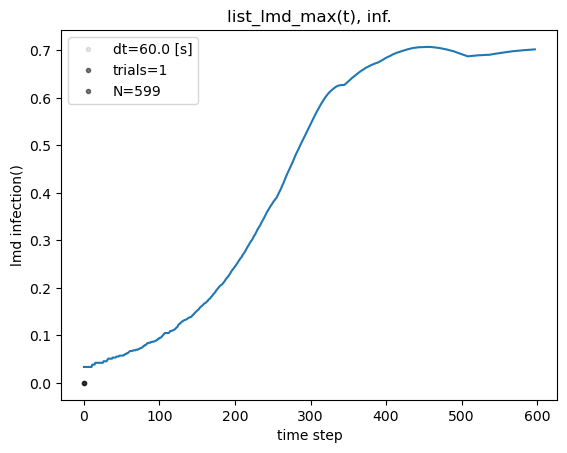

shape lmd list: (598,)
type lmd list: <class 'float'>


80000.0

In [ ]:
'Plot list_lmd_max'
    # does it converge to 1?


plt.figure()
plt.plot(list_lmd_max)
plt.plot(0,0, 'k.', alpha=0.1, label=f'dt={dt*60*60:.1f} [s]')
plt.plot(0,0,'k.', alpha=0.5, label=f'trials={trials}')
plt.plot(0,0,'k.', alpha=0.5, label=f'N={N}')

# plt.plot(np.mean(list_sumb, axis=(1, 2)))
plt.title('list_lmd_max(t), inf.')
plt.xlabel('time step')
plt.ylabel('lmd infection()')
plt.legend()

# Save the figure
plt.savefig("04_lmd_max(t).png", dpi=300, bbox_inches='tight')

plt.show()

# print('shape list sumb:', np.shape(list_sumb))
# print('print max, list_sumb[0]:', np.max(list_sumb[0]))
# print('print max, list_sumb_end:', np.max(list_sumb_end))

print('shape lmd list:', np.shape(list_lmd_max))
print('type lmd list:', type(list_lmd_max[-1]))

eta

In [ ]:
# 'Inspect list_inf_moi'
#     # shielding

# list_inf_moi = np.array(list_inf_moi)
# print('shape list_inf_moi:', np.shape(list_inf_moi))
# 'how many indexes are > 0'
# mean_inf_moi = np.mean(list_inf_moi, axis=(1,2))        # mean over time
# cum_inf_moi = np.cumsum(mean_inf_moi)        # cumulative sum over time
# # sum_inf_moi = np.sum(list_inf_moi, axis=(1,2))        # sum over time
# # cum_inf_moi = np.cumsum(sum_inf_moi)        # cumulative sum over time

# 'Figure, time series'
# plt.figure()
# plt.plot(list_time, cum_inf_moi, label='mean inf_moi over time')
# plt.xlabel('time [h]')
# plt.ylabel('mean cumulative inf_moi')
# plt.title('cumulative Inf_moi over time, well-mixed')

# plt.savefig("06_cum_moi_inf(t).png", dpi=300, bbox_inches='tight')
# plt.legend()
# plt.show()



# # evaluate mean over time


In [ ]:
# Evaluate and save all densities, at end of simulation

list_dnst_sumb = []
list_dnst_phg = []
list_dnst_sumi = []
list_dnst_ntr = []

list_sumb_end = np.array(list_sumb_end)
list_phg_end = np.array(list_phg_end)
list_sumi_end = np.array(list_sumi_end)
list_ntr_end = np.array(list_ntr_end)

# shapes
print('shape list_sumb_end:', np.shape(list_sumb_end))
print('shape list_phg_end:', np.shape(list_phg_end))
print('shape list_sumi_end:', np.shape(list_sumi_end))
print('shape list_ntr_end:', np.shape(list_ntr_end))


print(np.shape(list_sumb_end)[0])
# loop over all trials

# work work: Hvordan indekserer man i en liste? Hvilken feil fikk jeg før? [i, :, :] funket ikke, mener jeg.
for i in range(np.shape(list_sumb_end)[0]):
    print('i:', i)
    
    density_b, b_k, av_stdb, av_std_meanb, std_ijb, std_mean_ijb, density_lattice_b, _ = radial_density_corner(list_sumb_end[i, :, :], L)
    density_phg, phg_k, av_stdphg, av_std_meanphg, _, _, density_lattice_phg, _ = radial_density_corner(list_phg_end[i, :, :], L)
    density_i, i_k, _, _, _, _, density_lattice_i, _ = radial_density_corner(list_sumi_end[i, :, :], L)
    density_ntr, ntr_k, _, _, _, _, density_lattice_ntr, _ = radial_density_corner(list_ntr_end[i, :, :], L)

    list_dnst_sumb.append(b_k)
    list_dnst_phg.append(phg_k)
    list_dnst_sumi.append(i_k)
    list_dnst_ntr.append(ntr_k)


# shapes
print('shape list_dnst_sumb:', np.shape(list_dnst_sumb))
print('shape list_dnst_phg:', np.shape(list_dnst_phg))
print('shape list_dnst_sumi:', np.shape(list_dnst_sumi))
print('shape list_dnst_ntr:', np.shape(list_dnst_ntr))


# save
np.save("code129_list_radial_sumb.npy", np.array(list_dnst_sumb))
np.save("code129_list_radial_phg.npy", np.array(list_dnst_phg))
np.save("code129_list_radial_sumi.npy", np.array(list_dnst_sumi))
np.save("code129_list_radial_ntr.npy", np.array(list_dnst_ntr))     # Inspect shape of this one, huh.


shape list_sumb_end: (1, 360, 360)
shape list_phg_end: (1, 360, 360)
shape list_sumi_end: (1, 360, 360)
shape list_ntr_end: (1, 360, 360)
1
i: 0
shape list_dnst_sumb: (1, 510)
shape list_dnst_phg: (1, 510)
shape list_dnst_sumi: (1, 510)
shape list_dnst_ntr: (1, 510)


In [ ]:
'Print all shapes'

# all trials, shape
print('shape save_prm:', np.shape(save_prm))
print('shape list_all_trials:', np.shape(save_all_trials))
print('shape list_plq_size:', np.shape(save_plq_size), '\n')

# r half
print('shape list_rhalf_all:', np.shape(list_rhalf_all))          # should be 3 dimensional? check later: (N/20, trials, len(list_b0))
print('shape save _rhalf _all:', np.shape(save_rhalf), '\n')          # 2d, only appends last trial for each b0

# save sumb
print('shape save_sumb:', np.shape(save_sumb))
print('shape save_phg:', np.shape(save_phg))
print('shape save_sumi:', np.shape(save_sumi))
print('shape save_ntr:', np.shape(save_ntr))
print('shape list_time:', np.shape(list_time), '\n')

# final populations
print('shape list_sumb_end:', np.shape(list_sumb_end))
print('shape list_phg_end:', np.shape(list_phg_end))
print('shape list_sumi_end:', np.shape(list_sumi_end))
print('shape list_ntr_end:', np.shape(list_ntr_end), '\n')
# print('shape sum_b:', np.shape(sum_b))
# print('shape P:', np.shape(P), '\n')

print('shape list_sumb:', np.shape(list_sumb))


# print('t_end:', t_end, '[h]')

shape save_prm: (1,)
shape list_all_trials: (1, 1)
shape list_plq_size: (1,) 

shape list_rhalf_all: (1, 1, 11)
shape save _rhalf _all: (1, 11) 

shape save_sumb: (1, 61, 360, 360)
shape save_phg: (1, 61, 360, 360)
shape save_sumi: (1, 61, 360, 360)
shape save_ntr: (1, 61, 360, 360)
shape list_time: (61,) 

shape list_sumb_end: (1, 360, 360)
shape list_phg_end: (1, 360, 360)
shape list_sumi_end: (1, 360, 360)
shape list_ntr_end: (1, 360, 360) 

shape list_sumb: (61, 360, 360)


**evaluate densities**

type sumb: <class 'numpy.int32'>
type phg: <class 'numpy.int32'>
type sumi: <class 'numpy.int32'>
type ntr: <class 'numpy.int32'>
shape b_k: (510,)
shape phg_k: (510,)
shape i_k: (510,)
shape ntr_k: (510,)


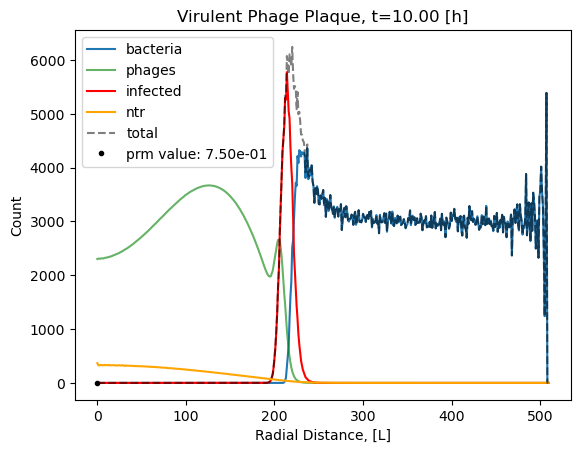

In [ ]:
# Evaluate density(r), for b, phg and i

list_sumb = np.array(list_sumb, dtype=np.int32)     # asd delete later?
list_phg = np.array(list_phg)
list_sumi = np.array(list_sumi)
list_ntr = np.array(list_ntr)

print('type sumb:', type(list_sumb[0,0,0]))     # write in the types above, asd 
print('type phg:', type(list_phg[0,0,0]))
print('type sumi:', type(list_sumi[0,0,0]))
print('type ntr:', type(list_ntr[0,0, 0]))


# density / abs. numbers for bacteria, phages and sum_i
density_b, b_k, av_stdb, av_std_meanb, std_ijb, std_mean_ijb, density_lattice_b, _ = radial_density_corner(list_sumb[-1, :, :], L)
density_phg, phg_k, av_stdphg, av_std_meanphg, _, _, density_lattice_phg, _ = radial_density_corner(list_phg[-1, :, :], L)
density_i, i_k, _, _, _, _, density_lattice_i, _ = radial_density_corner(list_sumi[-1, :, :], L)
density_ntr, ntr_k, _, _, _, _, density_lattice_ntr, _ = radial_density_corner(list_ntr[-1, :, :], L)

'density(r), so we get a 1D array for absolute phage numbers, as a function of r'
print('shape b_k:', b_k.shape)              # goodie
print('shape phg_k:', phg_k.shape)
print('shape i_k:', i_k.shape)
print('shape ntr_k:', ntr_k.shape)

plt.figure()
plt.plot(b_k, label='bacteria')
plt.plot(phg_k, color='green', alpha=0.6, label='phages')
plt.plot(i_k, color='red', label='infected')
plt.plot(ntr_k, color='orange', label='ntr')

plt.plot(b_k+i_k, 'k--', alpha=0.5, label='total')
plt.plot(0,0,'k.', label=f'prm value: {list_prm_[-1]:.2e}')

plt.title(f'Virulent Phage Plaque, t={t_end:.2f} [h]')
plt.xlabel('Radial Distance, [L]')
plt.ylabel('Count')
plt.legend()

# Save the figure
plt.savefig("01_profile(r).png", dpi=300, bbox_inches='tight')

plt.show()


**Plot Profile(r), Log space**

In [ ]:
# asd asd, buddy

mean sum_b: 4110.509889672995


C:\Users\Acer\AppData\Local\Temp\ipykernel_28464\4163344897.py:18: RuntimeWarning: divide by zero encountered in log
  plt.plot(list_time, np.log(np.mean(list_phg, axis=(1, 2))), color='green', alpha=0.6, label='phages')


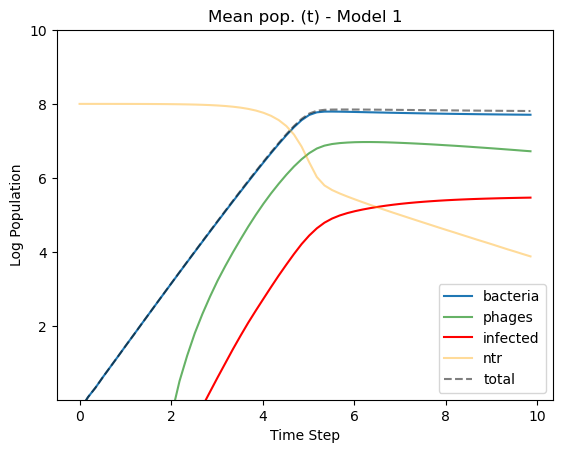

In [ ]:
# work work
# Plot mean trajectories of populations over time. When is sum_b capped?

'evaluate mean of sum_b, where sum_b>0'
mean_sum_b = np.mean(sum_b[sum_b>0])
print('mean sum_b:', mean_sum_b)

# Plot mean trajectories
plt.figure()
'normal space'
# plt.plot(np.mean(list_sumb, axis=(1, 2)), label='bacteria')
# plt.plot(np.mean(list_phg, axis=(1, 2)), color='green', alpha=0.6, label='phages')
# plt.plot(np.mean(list_sumi, axis=(1, 2)), color='red', label='infected')
# plt.plot(np.mean(list_ntr, axis=(1, 2)), color='orange', label='ntr')
# plt.plot(np.mean(list_sumb, axis=(1, 2)) + np.mean(list_sumi, axis=(1, 2)), 'k--', alpha=0.5, label='total')
'log space'
plt.plot(list_time, np.log(np.mean(list_sumb, axis=(1, 2))), label='bacteria')
plt.plot(list_time, np.log(np.mean(list_phg, axis=(1, 2))), color='green', alpha=0.6, label='phages')
plt.plot(list_time, np.log(np.mean(list_sumi, axis=(1, 2))), color='red', label='infected')
plt.plot(list_time, np.log(np.mean(list_ntr, axis=(1, 2))), alpha = 0.4, color='orange', label='ntr')
plt.plot(list_time, np.log(np.mean(list_sumb, axis=(1, 2)) + np.mean(list_sumi, axis=(1, 2))), 'k--', alpha=0.5, label='total')

# plt.plot(0,0,'k.', label=f'prm value: {list_prm_[-1]:.2e}')
# plt.plot(0,0,'k.', label=f't_end={t_end:.2f} [h]')

plt.title('Mean pop. (t) - Model 1')
plt.xlabel('Time Step')
plt.ylabel('Log Population')
plt.ylim(10**(-2), 10**(1))        # asd, adjust later
plt.legend()
# Save the figure
plt.savefig("01.1_mean_trajectory.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
'Save final radial densities'

# save radial profiles
np.savetxt("code129_radial_sum_b.csv", b_k, delimiter=",")
np.savetxt("code129_radial_phg.csv", phg_k, delimiter=",")
np.savetxt("code129_radial_sum_i.csv", i_k, delimiter=",")
np.savetxt("code129_radial_ntr.csv", ntr_k, delimiter=",")

# save total
np.savetxt("code129_radial_total_bi.csv", b_k+i_k, delimiter=",")


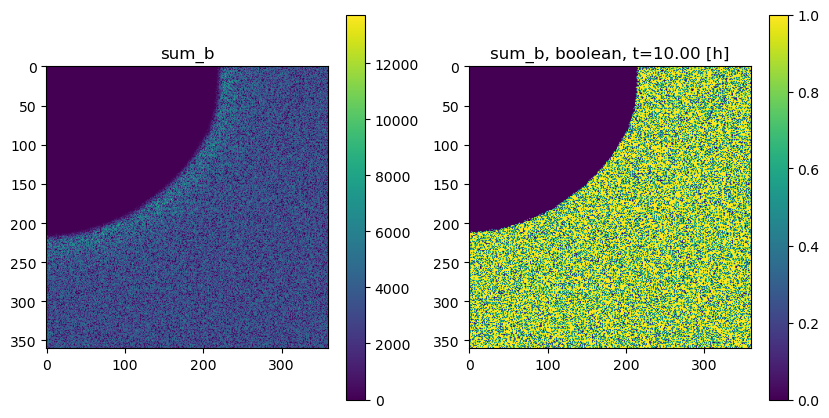

In [ ]:
# Sum_b

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cax0 = ax[0].imshow(sum_b, cmap='viridis')       # 
fig.colorbar(cax0, ax=ax[0])
ax[0].set_title(f'sum_b')

cax1 = ax[1].imshow(sum_b > 1, cmap='viridis')
fig.colorbar(cax1, ax=ax[1])
ax[1].set_title(f'sum_b, boolean, t={t_end:.2f} [h]')

# Save the figure
plt.savefig("02.1_sum_b.png", dpi=300, bbox_inches='tight')

plt.show()

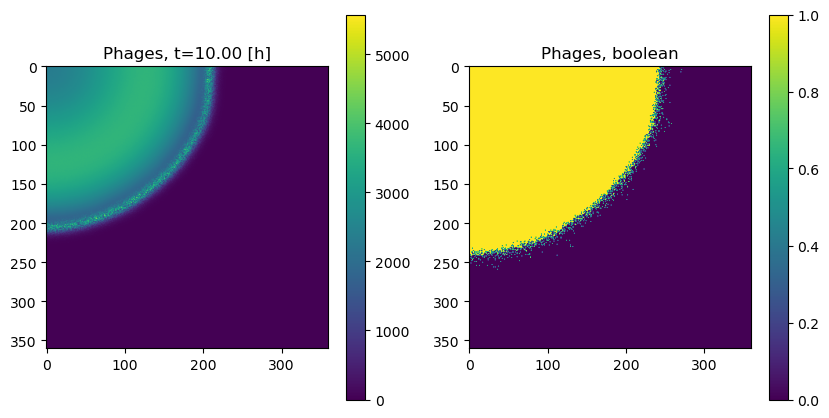

In [ ]:
# Plot phg: Phages

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cax0 = ax[0].imshow(P, cmap='viridis')       # 
fig.colorbar(cax0, ax=ax[0])
ax[0].set_title(f'Phages, t={t_end:.2f} [h]')

cax1 = ax[1].imshow(P>0, cmap='viridis')
fig.colorbar(cax1, ax=ax[1])
ax[1].set_title(f'Phages, boolean')

# Save the figure
plt.savefig("02.2_phg.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# asd asd

In [ ]:
'Save position of Phage Front, for all trials'

# save_phg = np.load('save_phg.npy')
# print('save_phg shape:', save_phg.shape)

list_phg_front0 = []
list_phg_front = []

for i in tqdm (range (save_phg.shape[0])):     # loop over no. trials          
    # print('save_phg.shape[0]:', save_phg.shape[0])

    list_P_radial = []
    list_P_front0 = []

    for j in range(save_phg.shape[1]):

        # print('phg1.')
        # print('j:', j)
        phg1 = save_phg[i, j, :, :]
        density_phg, phg_k, av_stdphg, av_std_meanphg, _, _, density_lattice_phg, _ = radial_density_corner(phg1, L)
        # density_phg, phg_k, av_stdphg, av_std_meanphg, _, _, density_lattice_phg, _ = radial_density_corner(phg1[j, :, :], L)

        # evaluate index for front
        index_list = np.argwhere(phg_k > 0)
        if len(index_list) == 0:
            index_front = 0
        else:
            index_front = index_list[-1]
    
        # save front
        # list_P_radial.append(phg_k)
        list_P_front0.append(index_front*L)

    list_phg_front.append(list_P_front0)     # save front for all trials

# work work, does it work?

100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


In [ ]:
# Adjust result
list_phg_front = np.float32(list_phg_front)
print('shape list_phg_front:', np.shape(list_phg_front))            #  np.float32, from np.float64
# print('type list_phg_front:', type(list_phg_front[0][0]))

save_phg_front = np.array(list_phg_front)

# Save result
np.save("code129_list_phg_front.npy", save_phg_front)           # End list has dimensions (trials, no. snapshots in time)

shape list_phg_front: (1, 61)


C:\Users\Acer\AppData\Local\Temp\ipykernel_28464\2133881410.py:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  list_phg_front = np.float32(list_phg_front)


n_t: 61


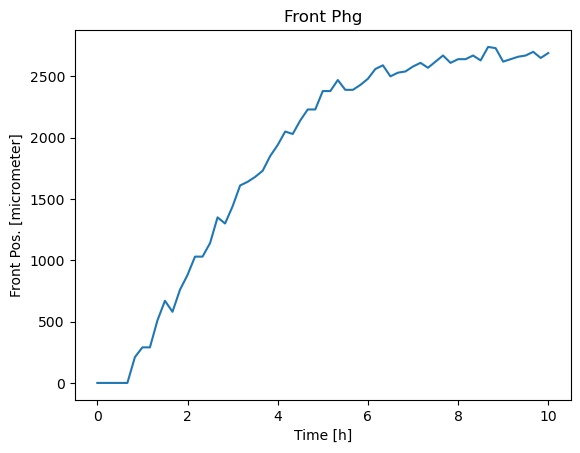

shape all phg front: (1, 61)
list_phg_front_max: [2740.0]


In [ ]:
'Plot 1 trial, Phage Front'
    # we save for every 20th minute

k = 0          # pick trial, for plot

n_t = len(save_phg_front[k, :])
print('n_t:', n_t)

plot_time = np.linspace(0, 10, n_t)     # t_end = 10


plt.figure()
plt.plot(plot_time, save_phg_front[k, :])
plt.title('Front Phg')
plt.xlabel('Time [h]')
plt.ylabel('Front Pos. [micrometer]')

# Save the figure
plt.savefig("05_phg_front.png", dpi=300, bbox_inches='tight')

plt.show()

# Save phage front
print('shape all phg front:', np.shape(save_phg_front))

list_phg_front_max = []
if np.shape(list_phg_front)[0] > 0:
    for i in range(np.shape(list_phg_front)[0]):
        list_phg_front_max.append(np.max(list_phg_front[i, :]))

    print('list_phg_front_max:', list_phg_front_max)
    list_phg_front_max = np.array(list_phg_front_max)
    np.save("code129_result_phg_front_max.npy", list_phg_front_max)           # (no. trials, )


**R_half: plaque delay and speed**

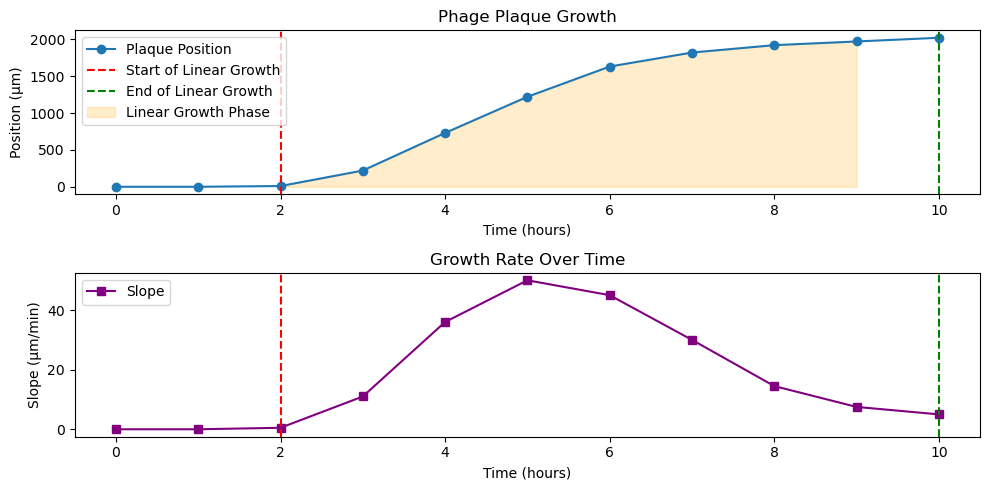

Movement starts at index: 2 (Time ≈ 2.00 h)
Linear phase ends at index: 10 (Time ≈ 10.00 h)
Mean slope (slope1) during linear phase: 24.31 µm/min


In [ ]:
'Evaluate delay and speed of plaque / r_half'

def analyze_plaque_growth(positions, dt=10):               # why have dt in minutes though? Guess it's arbitrary.
# def analyze_plaque_growth(positions, dt=i_skip/2*3):

    ' positions (np.array): Array of plaque positions over time.'
    ' dt (float): Time step in minutes.'
    
    # Returns:
    #     start_index (int): Index where movement begins.
    #     end_index (int): Index where the fast phase ends.
    #     slope1 (float): Mean slope during the fast movement phase.
    #     slopes (np.array): Computed slopes over time.
    

    # Compute numerical slopes (Δposition / Δtime)
    slopes0 = np.diff(positions) / dt  
    
    slopes = np.zeros_like(positions)
    positions = np.array(positions)
    slopes[2:] = (positions[2:] - positions[:-2]) / (2*dt)  # 2nd order central difference

    # Find the start of motion: first index where slope becomes significantly positive
    threshold = 3 # Define a threshold for motion (tunable)

    if np.where(slopes0 > threshold)[0].size > 0:
        start_index = np.where(slopes0 > threshold)[0][0]
    else:
        start_index = 0
    # start_index = np.where(slopes0 > threshold)[0][0]  
    'gives error, if slopes is nowhere > threshold'

    threshold2 = 1.5        # arbitrary, so keep fine-tuning... Gott.
    if np.where(slopes > threshold2)[0].size > 0:
        end_index = np.where(slopes > threshold2)[0][-1]
    else:
        end_index = 0

        
    # end_index = np.where(slopes > threshold2)[0][-1]
    # 
    # # Identify the linear phase (Slope 1 period)
    # slope_threshold = np.mean(slopes[start_index:]) * 0.99  # At least 70% of mean slope, maybe tune?
    # candidates = np.where(slopes > slope_threshold)[0]  

    # if len(candidates) > 0:
    #     end_index = candidates[-1]  # Last point in high-slope region
    # else:
    #     end_index = start_index + 1  # Fallback

    # Compute mean slope in the identified range
    slope1 = np.mean(slopes[start_index:end_index])

    return start_index, end_index, slope1, slopes

# Evaluate slope and delay
positions = list_rhalf
x0 = len(list_rhalf)
# print(x0)
plot_time = np.linspace(0, t_end, x0)
time = plot_time

start_idx, end_idx, slope1, slopes = analyze_plaque_growth(positions)

'see if end_dx == 0. then save speed as delay as 0'
if end_idx == 0:
    list_delay = np.array([0, 0, 0])
    list_speed = np.array([0, 0, 0])
    np.savetxt("code129_list_delay.csv", np.array(list_delay), delimiter=",")       # [h]
    np.savetxt("code129_list_speed.csv", np.array(list_speed), delimiter=",")       # [micrometer/h]

# Plot plaque position
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time, positions, marker='o', linestyle='-', label="Plaque Position")
plt.axvline(time[start_idx], color='r', linestyle='--', label="Start of Linear Growth")
plt.axvline(time[end_idx], color='g', linestyle='--', label="End of Linear Growth")
plt.fill_between(time[start_idx:end_idx], positions[start_idx:end_idx], alpha=0.2, color='orange', label="Linear Growth Phase")
plt.xlabel("Time (hours)")
plt.ylabel("Position (µm)")
plt.legend()
plt.title("Phage Plaque Growth")

# Plot slopes
# time_slope = time[:-1]  # Slopes are between time intervals
time_slope = time  # Slopes are between time intervals
plt.subplot(2, 1, 2)

plt.plot(time_slope, slopes, marker='s', linestyle='-', color='purple', label="Slope")
plt.axvline(time[start_idx], color='r', linestyle='--')
plt.axvline(time[end_idx], color='g', linestyle='--')
plt.xlabel("Time (hours)")
plt.ylabel("Slope (µm/min)")
plt.legend()
plt.title("Growth Rate Over Time")

plt.tight_layout()
plt.show()

# Print results
print(f"Movement starts at index: {start_idx} (Time ≈ {time[start_idx]:.2f} h)")
print(f"Linear phase ends at index: {end_idx} (Time ≈ {time[end_idx]:.2f} h)")
print(f"Mean slope (slope1) during linear phase: {slope1:.2f} µm/min")


end_edx: 10
shape list_time: (61,)
shape list_rhalf: (11,)
shape plot_time: (11,)


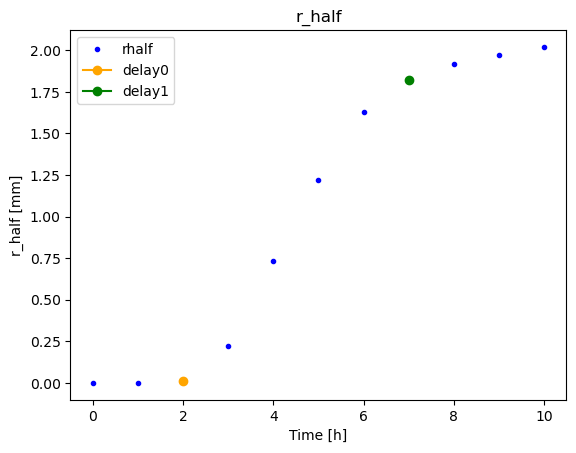

[   0.    0.   10.  220.  730. 1220. 1630. 1820. 1920. 1970. 2020.]


In [ ]:
'Plot r_half over time'

list_time = np.array(list_time)     # asd, delete later
list_rhalf = np.array(list_rhalf)


x0 = len(list_rhalf)
print('end_edx:', end_idx)
start_idx = np.int32(start_idx)
if end_idx > 0:
    end_idx = np.int32(end_idx - 3)



# print(x0)
plot_time = np.linspace(0, t_end, x0)
print('shape list_time:', list_time.shape)
print('shape list_rhalf:', list_rhalf.shape)
print('shape plot_time:', plot_time.shape)


# Figure
plt.figure()
plt.plot(plot_time, list_rhalf/1000, 'b.', label='rhalf')
# plt.plot(plot_time[1:], slope/1000, 'r.', label='slope')

# start_idx, end_idx, slope1, slopes = analyze_plaque_growth(positions)
# plt.plot(plot_time[index_delay0], list_rhalf[index_delay0]/1000, 'ro', label='delay0')
# plt.plot(plot_time[index_delay1], list_rhalf[index_delay1]/1000, color='orange', marker='o', label='delay1')
# plt.plot(plot_time[start_idx], list_rhalf[start_idx]/1000, 'ro', label='delay0')
plt.plot(plot_time[start_idx], list_rhalf[start_idx]/1000, color='orange', marker='o', label='delay0')
plt.plot(plot_time[end_idx], list_rhalf[end_idx]/1000, color='green', marker='o', label='delay1')
plt.xlabel('Time [h]')
plt.ylabel('r_half [mm]')
plt.title('r_half')
plt.legend()

# Save the figure
plt.savefig("03_rhalf(t).png", dpi=300, bbox_inches='tight')
plt.show()

'similar to Paper 2016, but we need to see what happens after 10 hours?'    # asd asd

print(list_rhalf)

start index: 2
end index: 7
len, list_fit_data: 5
slope_1: 2035.2000000000003 



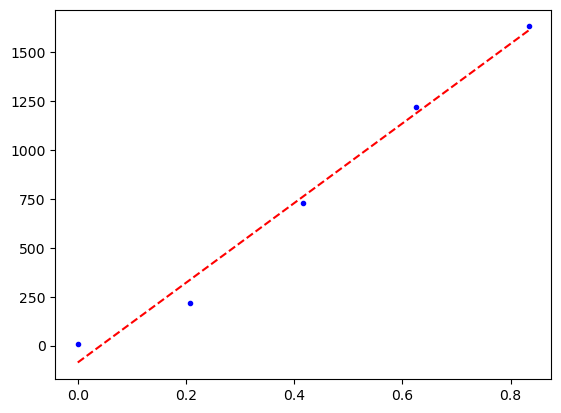

In [ ]:

# start_idx, end_idx


# define linear fit
len0 = len(list_rhalf[start_idx:end_idx])
plot0 = np.linspace(0, len0, len0)*(10/60)
# plot0 = np.linspace(0, len0, len0)*(i_skip_rhalf/60)
lin1 = np.polyfit(plot0, list_rhalf[start_idx: (end_idx)], 1)
slope_1 = lin1[0]


# print
print('start index:', start_idx)
print('end index:', end_idx)
print('len, list_fit_data:', len0)
print('slope_1:', slope_1, '\n')
# print('slope1, manual fit:', slope1)                  # mean slope, in identified growth region (phase 1, type). This region is often ill-determined, though.

# Plot
plt.plot(plot0, list_rhalf[start_idx:end_idx], 'b.')
plt.plot(plot0, lin1[0]*plot0 + lin1[1], 'r--')




# plt.plot(plot0, slope1*60*plot0, 'r--')

# plot a linear fit of same length as above, with slope = slope1

# print(list_rhalf[5:24])
# print(slope1)


In [ ]:
# Save Result

print('shape list all r half:', np.shape(list_rhalf_all))          # should be 3 dimensional? check later: (N/20, trials, len(list_b0))


x0 = len(list_rhalf)
# print(x0)
plot_time = np.linspace(0, t_end, x0)

list_delay = []
list_speed = []

for i in range(np.shape(list_rhalf_all)[0]):
    list_delay0 = []
    list_speed0 = []
    
    for j in range(np.shape(list_rhalf_all)[1]):

        print('\n', 'j:', j)    
        # evaluate slope, for each trial
        start_index, end_index, slope1, slopes = analyze_plaque_growth(list_rhalf_all[i, j, :])
        if end_index > 0:
            end_index = np.int32(end_index - 3)
        
        # for fitting
        len0 = len(list_rhalf[start_idx:end_idx])
        plot0 = np.linspace(0, len0, len0)*(10/60)              # ASD, watch out for hat interval of minutes we are looking at
        # plot0 = np.linspace(0, len0, len0)*(i_skip_rhalf/60)              # ASD, watch out for hat interval of minutes we are looking at

        # linear fit
        lin1 = np.polyfit(plot0, list_rhalf_all[i, j, start_idx:end_idx], 1)    # linear fit, 1st order polynomial
        slope_1 = lin1[0]

        # print stuff?
        print('start index:', start_idx)
        print('end index:', end_idx)
        print('len list_fit_data:', len0)
        print('slope_1:', slope_1, '\n')

        # append delay [h] and speed [micrometer/h]
        list_delay0.append(np.float32( plot_time[start_index] ))      # np.int32: append delay, where plaque starts to move
        list_speed0.append(np.float32 (slope_1 ))                   # np.float32: append speed, for plaque growth; evaluated in minutes -> hours

    list_delay.append(list_delay0)      # list delay 
    list_speed.append(list_speed0)      # list speed

'Save list for delays + speeds: Delay in hours, and speed in micrometer/h.'
print('shape list_delay:', np.shape(list_delay))
print('shape list_speed:', np.shape(list_speed))

print('list_delay:', list_delay)
print('list_speed:', list_speed)

np.savetxt("code129_result_delay.csv", np.array(list_delay), delimiter=",")       # [h]
np.savetxt("code129_result_speed.csv", np.array(list_speed), delimiter=",")       # [micrometer/h]


shape list all r half: (1, 1, 11)

 j: 0
start index: 2
end index: 7
len list_fit_data: 5
slope_1: 2035.2000000000003 

shape list_delay: (1, 1)
shape list_speed: (1, 1)
list_delay: [[2.0]]
list_speed: [[2035.2]]


In [ ]:
# # Plot
# plt.plot(plot0, list_rhalf[start_idx:end_idx-90], 'b.')

# plt.plot(plot0, slope_1 * plot0 + lin1[1], 'r--')

# # plt.plot(plot0, list_speed[0] * plot0 + lin1[1], 'r--')

# print('slope_1:', slope_1)

In [ ]:
# asd asd